In [1]:
from PIL import Image
import numpy as np
import glob
import os
from configs.scannet_constants import *
from tqdm.notebook import tqdm
import argparse
import pandas as pd
import math

In [2]:
THRESHOLD = 0 ## Number of pixels to start from the beginning and end from the end of the image to crete the center.

gt_dir = "/home/rozenberszki/Downloads/ScanNet-novel/"
list_dirs = sorted(glob.glob(gt_dir+'/**', recursive=False))
class_dist = {}
class_dist[0] = {
    "sum":0,
    "scenes":{

    }
}
# for i in range(21):
#     if(i==0): continue
#     class_dist[VALID_CLASS_IDS_20[i-1]]=0
for key in VALID_CLASS_IDS_20:
    class_dist[key]={
        "sum":0,
        "scenes":{

        }
    }

scene_def = {
    "poses":[

    ]
}

In [3]:
for tqdm_idx in tqdm(range(len(list_dirs))):
    scene = list_dirs[tqdm_idx]
    if(scene.endswith("_01")): continue
    if(scene.endswith("_02")): continue
    for image in sorted(glob.glob(os.path.join(gt_dir, scene, '**'), recursive=False)):
        if(image.endswith(".png")): continue
        img = np.load(image, allow_pickle=True)
        scene_id = scene.split("/")[-1]
        pose_id = image.split("/")[-1]
        shrink = img
        shrink = shrink[THRESHOLD:shrink.shape[0]-THRESHOLD,THRESHOLD:shrink.shape[1]-THRESHOLD]
        img = shrink
        for key in range(21):
            if(key==0): 
                sum_pts = (img==key).sum()
                class_dist[key]["sum"]+=(img==key).sum()
                if(sum_pts > 0):
                    if(scene_id not in class_dist[key]["scenes"]):
                        class_dist[key]["scenes"][scene_id]={
                        "sum":(img==key).sum(),
                        "poses":{
                            pose_id: (img==key).sum()
                        }  
                        }
                    else:
                        class_dist[key]["scenes"][scene_id]["sum"]+=(img==key).sum()
                        class_dist[key]["scenes"][scene_id]["poses"][pose_id] = (img==key).sum()
                continue
            new_key = VALID_CLASS_IDS_20[key-1] ## Key
            # idx = img==key
            sum_pts = (img==key).sum()
            class_dist[new_key]["sum"]+= sum_pts
            if(sum_pts > 0):
                if(scene_id not in class_dist[new_key]["scenes"]):
                    class_dist[new_key]["scenes"][scene_id]={
                        "sum":(img==key).sum(),
                        "poses":{
                        pose_id: (img==key).sum()
                        }  
                    }
                else:
                    class_dist[new_key]["scenes"][scene_id]["sum"]+=(img==key).sum()
                    class_dist[new_key]["scenes"][scene_id]["poses"][pose_id] = (img==key).sum()

  0%|          | 0/327 [00:00<?, ?it/s]

In [4]:
np.save("../../Downloads/class_dist_novel_8.npy", class_dist)

## Load the class distribution and Analyze

In [5]:
load = np.load("../../Downloads/class_dist_novel_8.npy", allow_pickle='TRUE').item()

In [6]:
class_ids = list(load.keys())
class_vals = []
for key in load.keys():
    class_vals.append(load[key]["sum"])

In [7]:
classes = list(tuple('i')+CLASS_LABELS_20)
classes[0]="Undefined"
quick_sum = {}
for i, id in enumerate(class_ids):
    quick_sum[id]=class_vals[i]
df = pd.DataFrame(quick_sum.items(), columns=["Class","Values"])
df.loc['Total'] = pd.Series(df['Values'].sum(), index=['Values'])
df['Percentage'] = df['Values']/df['Values'].sum() *200
df['Class_Name'] = classes+["Name"]
sorted_list = df.sort_values(by='Values', ascending=False)
display(sorted_list)

,Class,Values,Percentage,Class_Name
Total,NaN,368673324.0,100.000000,Name
1,1.0,79583806.0,21.586538,wall
14,16.0,47787953.0,12.962140,curtain
0,0.0,46301319.0,12.558901,Undefined
2,2.0,31482941.0,8.539522,floor
12,12.0,27831305.0,7.549042,counter
3,3.0,22760653.0,6.173664,cabinet
15,24.0,18129496.0,4.917496,refrigerator
19,36.0,15383764.0,4.172736,bathtub
16,28.0,14786026.0,4.010604,shower curtain


['Undefined', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'desk', 'curtain', 'refrigerator', 'shower curtain', 'toilet', 'sink', 'bathtub', 'otherfurniture']


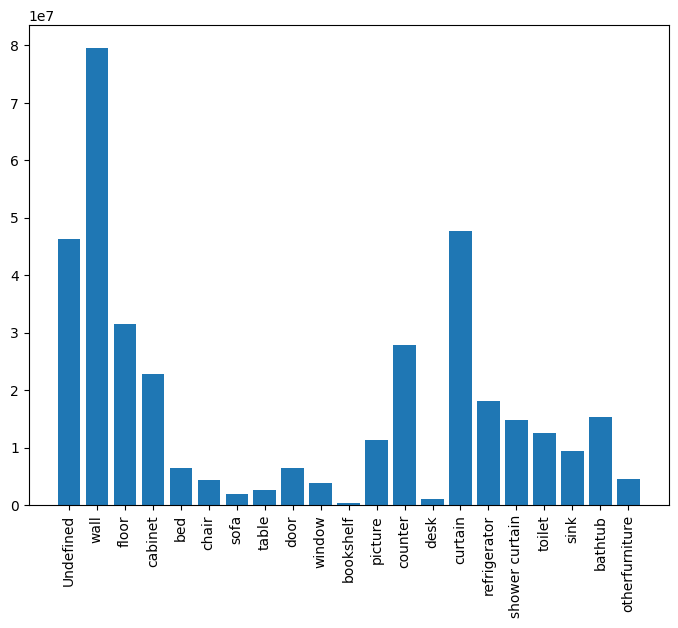

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import math
from configs.scannet_constants import *
import pandas as pd
from IPython.display import display, HTML
%matplotlib inline

class_ids = list(load.keys())
class_vals = []
for key in load.keys():
    class_vals.append(load[key]["sum"])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = list(tuple('i')+CLASS_LABELS_20)
classes[0]="Undefined"
print(classes)
plt.xticks(rotation='vertical')
ax.bar(classes,class_vals)
plt.show()

## Get the 6 least represented classes

In [22]:
least_6 = sorted_list.iloc[-8:]


display(least_6)

for Class in least_6['Class']:
    print(Class)
    class_key = int(Class)
    print(load[class_key]['sum']) 
    print("Scenes List:")
    for k in load[class_key]['scenes'].keys():
        print(k,":",load[class_key]['scenes'][k]['sum'])

,Class,Values,Percentage,Class_Name
14,16.0,19179373.0,1.023104,curtain
15,24.0,14490516.0,0.772981,refrigerator
12,12.0,13400273.0,0.714824,counter
17,33.0,12626147.0,0.673529,toilet
19,36.0,12112551.0,0.646131,bathtub
11,11.0,8678681.0,0.462955,picture
16,28.0,8675174.0,0.462768,shower curtain
18,34.0,8031682.0,0.428442,sink


16.0
19179373
Scenes List:
plenoxel_scannet_scene0000_00 : 262960
plenoxel_scannet_scene0000_01 : 352674
plenoxel_scannet_scene0000_02 : 313111
plenoxel_scannet_scene0006_00 : 93176
plenoxel_scannet_scene0006_01 : 133022
plenoxel_scannet_scene0006_02 : 170386
plenoxel_scannet_scene0016_00 : 165873
plenoxel_scannet_scene0016_01 : 132273
plenoxel_scannet_scene0016_02 : 138417
plenoxel_scannet_scene0046_00 : 141501
plenoxel_scannet_scene0046_01 : 126351
plenoxel_scannet_scene0046_02 : 249156
plenoxel_scannet_scene0049_00 : 53985
plenoxel_scannet_scene0053_00 : 6689
plenoxel_scannet_scene0061_00 : 111294
plenoxel_scannet_scene0066_00 : 21060
plenoxel_scannet_scene0070_00 : 70917
plenoxel_scannet_scene0072_00 : 29084
plenoxel_scannet_scene0072_01 : 16447
plenoxel_scannet_scene0072_02 : 13701
plenoxel_scannet_scene0073_00 : 201699
plenoxel_scannet_scene0073_01 : 131527
plenoxel_scannet_scene0073_02 : 92073
plenoxel_scannet_scene0073_03 : 53030
plenoxel_scannet_scene0074_00 : 111345
plenoxel_

In [3]:
depth = np.load("../../Downloads/ScanNet-gt-124-depth/plenoxel_scannet_scene0000_00/0_depth.npy", allow_pickle='TRUE')

In [6]:
d_sq = depth.squeeze()
print(d_sq)

[[2.293 2.299 2.307 ... 1.553 1.559 1.562]
 [2.297 2.303 2.31  ... 1.555 1.56  1.564]
 [2.3   2.307 2.312 ... 1.558 1.562 1.566]
 ...
 [1.714 1.714 1.714 ... 1.715 1.715 1.715]
 [1.7   1.7   1.7   ... 1.701 1.701 1.702]
 [1.687 1.687 1.687 ... 1.688 1.688 1.688]]



# Old Distribution

In [9]:
load_old = np.load("../../Downloads/class_dist_advanced.npy", allow_pickle='TRUE').item()

['Undefined', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'desk', 'curtain', 'refrigerator', 'shower curtain', 'toilet', 'sink', 'bathtub', 'otherfurniture']


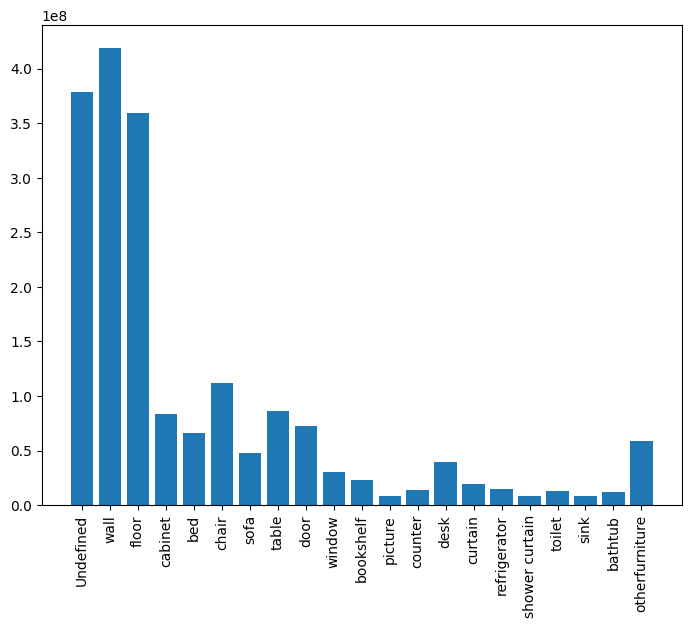

In [16]:
class_ids_old = list(load_old.keys())
class_vals_old = []
for key in load.keys():
    class_vals_old.append(load_old[key]["sum"])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes_old = list(tuple('i')+CLASS_LABELS_20)
classes_old[0]="Undefined"
print(classes_old)
plt.xticks(rotation='vertical')
ax.bar(classes_old,class_vals_old)
plt.show()

In [12]:
print(len(class_vals))
print(len(class_vals_old))


21
21


['Undefined', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'desk', 'curtain', 'refrigerator', 'shower curtain', 'toilet', 'sink', 'bathtub', 'otherfurniture']


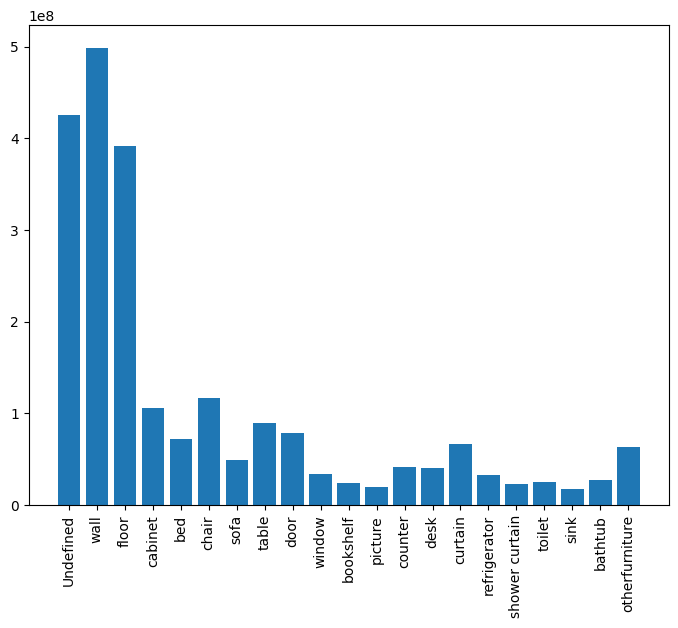

In [17]:
new_class_vals = np.add(class_vals, class_vals_old)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes_old = list(tuple('i')+CLASS_LABELS_20)
classes_old[0]="Undefined"
print(classes_old)
plt.xticks(rotation='vertical')
ax.bar(classes_old,new_class_vals)
plt.show()

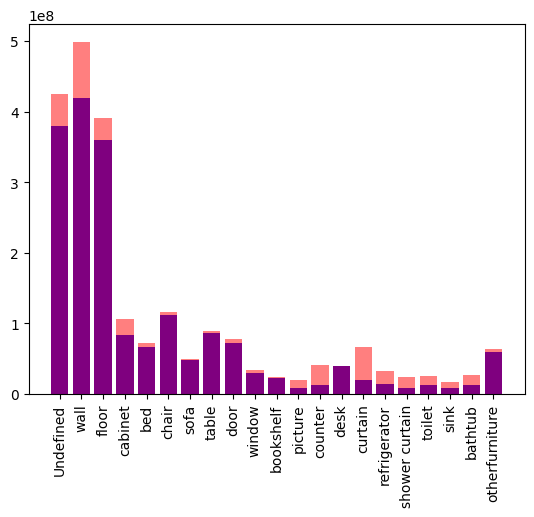

In [22]:
plt.xticks(rotation='vertical')
plt.bar(classes_old[1:],class_vals_old[1:], color='b')
plt.bar(classes_old[1:],new_class_vals[1:], color='r', alpha=0.5)
plt.show()